***
<p style="text-align:left;">Reinforcement Learning
<span style="float:right;">Monday, 08. June 2020</span></p>

<p style="text-align:left;">Prof. S. Harmeling
<span style="float:right;">DUE 23:55 Monday, 15. June 2020</span></p>

---
<p style="text-align:center;"><b>Exercise set #8</b></p>

---

# 1. Sarsa(λ)

In this exercise you will implement **Sarsa(λ)** with replacing traces and $\epsilon$-greedy action selection.  
(Example 10.1 from [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto, p. 244ff)

In [1]:
import gym
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tiles3

In [2]:
mpl.rcParams['figure.figsize'] = (8, 5)
mpl.rcParams['lines.linewidth'] = 2

## Mountain Car Environment

In this exercise we will work with the **Mountain Car** environment from OpenAI's gym library.  
The three actions (decelerate, coast, and accelerate) in the mountain car problem are represented by the integers 0, 1, and 2.  
The states are represented by a numpy array of doubles corresponding to the position and velocity of the car.  
Make yourself familiar with the environment:
- https://gym.openai.com/envs/MountainCar-v0
- https://github.com/openai/gym/wiki/MountainCar-v0

In [3]:
env = gym.make('MountainCar-v0').env
env = gym.wrappers.TimeLimit(env, 1000)

In [4]:
total_reward = 0
state = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    total_reward += reward

print('The random policy reached a total reward of', total_reward)

The random policy reached a total reward of -1000.0


## Sarsa(λ)

We will implement the Sarsa(λ) algorithm from Chapter 12.7 from [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto, p. 303ff.  
We are going to use **replacing traces** and **ϵ-greedy action selection**.

<img src="https://miro.medium.com/max/3516/1*wcb9rZn27woQaliD7h4DLQ.png" width="600" height="400">

### Tile coding

In this assignment we will use **tile coding** to convert the two-dimensional state vector into
a binary state-action feature vector  
(for more details see Chapter 9.5.4 from [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) by Sutton and Barto, p.217ff).  

We have provided the tile coding software by Richard Sutton in ```tiles3.py```.  
To understand how to use it you should take a look inside this file.  

To do tile coding properly you have to: 
- account for the shape of the tilings and ranges of the position and velocity before calling the tile coder, and 
- incorporate the action into the call to the tile coder.

We will use the following parameter settings:  
- memorySize = 4096 (for the tile coder)
- num tilings = 8; shape/size of tilings = 8x8
- $\alpha = 0.1 /$(num tilings)
- $\lambda = 0.9$
- $\epsilon = 0.0$
- initial weights = random numbers between 0 and -0.001
- $\gamma = 1$

Implement the missing parts of the Sarsa agent below:

In [101]:
class SarsaAgent:
    
    def __init__(self, env):
        self.s_min = env.observation_space.low
        self.s_max = env.observation_space.high
        self.iht = tiles3.IHT(4096)
        self.w = np.random.uniform(-0.001, 0., 4096)
    
    def action_value(self, s, a):
        #########################
        # Write your code here. #
        q =  np.sum(self.w[self.features(s,a)])
        #########################
        return q
    
    def features(self, s, a):
        #########################
        scale_pos = 8.0/(1.8)
        scale_velo = 8.0/0.14
        x = tiles3.tiles(self.iht, 8, (s[0]*scale_pos, s[1]*scale_velo), [a])
        #########################
        return x
    
    def choose_action(self, env, s, epsilon=0):
        #########################
        if np.random.binomial(1, epsilon) == 1:
            action = np.random.randint(0, 3)
        else:
            action = np.argmax([self.action_value(s, a) for a in range(0,3)])
        return action
        #########################
    
    def train(self, env, alpha, lamda, gamma, epsilon):
        state = env.reset()
        action = self.choose_action(env, state, epsilon)
        z = np.zeros(4096)
        num_steps = 0
        done = False
        while not done:
            next_state, reward, done, info = env.step(action)
            
            #########################
            delta = reward
            F = self.features(state, action)
            for i in range(len(F)):
                idx = F[i]
                delta -= self.w[idx]
                z[idx] = 1
            if done:
                self.w = self.w + alpha * delta * z
            action = self.choose_action(env, next_state, epsilon)
            next_next_state, reward, done, info = env.step(action)
            F = self.features(next_state, action)
            for i in range(len(F)):
                idx = F[i]
                delta -= self.w[idx]
            self.w = self.w + alpha * delta * z
            z = gamma * lamda * z
            state = next_state

            #########################
            
            num_steps += 1
            if num_steps == 200:
                done = True
        return num_steps

### Results

Now we can test your implementation. We produce a learning curve for the Sarsa agent and plot the number of steps  
per episode (x-axis), over 200 episodes (y-axis), averaged over 10 independent runs:

In [102]:
num_runs = 1
num_episodes = 200

avg_num_steps = np.zeros(num_episodes)

for run in range(1, num_runs + 1):
    print('\rRun: {}/{}'.format(run, num_runs), end='', flush=True)
    agent = SarsaAgent(env)
    for episode in range(num_episodes):
        num_steps = agent.train(env, alpha=0.1/8, lamda=0.9, gamma=1, epsilon=0)
        avg_num_steps[episode] += num_steps

avg_num_steps /= num_runs

Run: 1/1

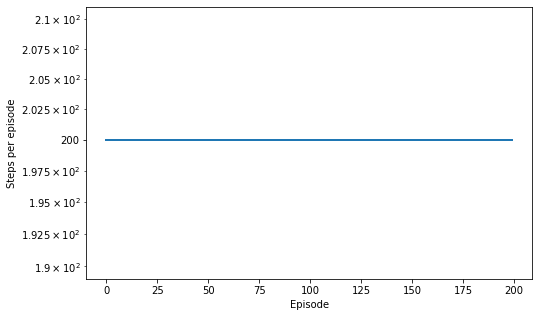

In [103]:
plt.xlabel('Episode')
plt.ylabel('Steps per episode')
plt.yscale('log')
plt.yticks([100, 200, 400, 1000])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.plot(avg_num_steps);